# 6. Classification, Regression
This section will cover logistic regression (which is a classification model, not regression) and linear regression. Once you can train both of these models, you know how to do both classification and regression in their simplest way possible. I first demonstrate how to train a logistic regression using the Iris dataset. As an exercise, you will train a linear regression on the Boston housing dataset.

This section will put together what we've learned so far, e.g. `session`, `placeholder`, `variable`, etc. This section might seem hard at first, but the only new concept that will be introduced here is the `GradientDescentOptimizer`. As long as you understand the code step by step, it should be ok.

## Logistic Regression

This example is partially adopted from [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.12/tutorials/mnist/pros/) tutorial from TensorFlow official website.

### Task

Classify a dataset of hand-written digits (0 through 9).

### Data

Let's load the data first. Thankfully, TensorFlow provided us a nice API. The data is also already split into train, validation and test set. In general, the data is much less clean.

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at the first image to get a sense of what is inside. Note that `next_batch` is an API provided by TensorFlow to get the next `n` images from the dataset. You generally have to code this up yourself.

In [17]:
batch = mnist.train.next_batch(1) # get one image from the data
plotData = batch[0]
plotData

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

There are $28\times 28=784$ pixels. $0$ means black and $1$ means white. Let's reshape it and use `matplotlib` to make it an image.

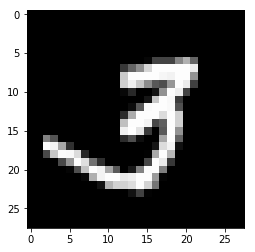

In [18]:
plotData = plotData.reshape(28, 28) # reshape to make image a matirx
plt.gray() # use this line if you don't want to see it in color
plt.imshow(plotData)
plt.show()

### Overview

We will build a softmax regression. Softmax regression is just a multi-class generalization of the logistic regression model:

$Y=softmax(XW+b)$
where

$Y: N \times K$. Labels. The labels are one-hot encoded.

$X: N \times M$. Features.

$W: M \times K$. Weights.

$b: K$. Bias

Here, $N$ can either be the train, validation, test sample size or the mini-batch size, depending on which part of the process you're in. $M$ is the number of features (784 in this case) and $K$ is the number of classes (10 in this case).

I really like to write down all the matrix dimensions before I start any coding. This way, I can avoid matrix dimension errors later on. This is kind of like creating an outline of your essay before you start drafting it.

The loss we would like to optimize is the cross-entropy loss, averaged over the sample size:

$$\frac{-\sum_{n=1}^N \sum_{k=1}^K y_{n,k} log(\hat{y}_{n,k})}{N}$$

We will train this using gradient descent. 

Coding of this model is a six step process:
1. Define variables and placeholders.
2. Define the model.
3. Define the loss function.
4. Define the optimizer.
5. Train the model, i.e. initialize variables and run optimizer.
6. Evaluate the model.

This is the same for any other models. Neural nets will have these steps too!

### Variables and Placeholders

$Y,X$ will be a placeholder, because we will feed in datasets with different shapes.

In [23]:
M = 784
K = 10

In [24]:
X = tf.placeholder(tf.float32, shape=[None, M])
Y = tf.placeholder(tf.float32, shape=[None, K])

$W,b$ will be variables, because we would like to mutate them every epoch via the gradient descent.

In [25]:
W = tf.Variable(tf.zeros([M, K])) # the variables will be all zeros initially
b = tf.Variable(tf.zeros([K]))

### Model
Softmax regression model is a one liner!

In [26]:
Yhat = tf.nn.softmax(X @W + b)

### Loss
The cross-entropy loss is also a one liner! Make sure to compare it with the equation above and check that it's doing what it's supposed to. We will also define accuracy for evaluating the result on the test set.

In [27]:
loss               = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(Yhat), axis=1))
# choose predictions from 10 classes and compare them with the true labels
correct_prediction = tf.equal(tf.argmax(Yhat, 1), tf.argmax(Y, 1))           
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

### Optimizer
Here's somethig new to learn! `GradientDescentOptimizer` takes in the objective that we would like to minimize. When we run this optimizer in a session, it will look for all trainable variables (or the specified list of variables, if any) and update them. There are many other optimizers e.g. `AdagradOptimizer`, `AdamOptimizer`. Find your favorite!

In [28]:
learning_rate = 0.01 # this is a hyperparameter to tune
optimizer = tf.train.GradientDescentOptimizer(learning_rate) # first initialize an optimizer
update = optimizer.minimize(loss) # then pass in the objective you would like to minimize

### Initialize variables and run optimizer, evaluate the model
The final step is to train the model, and then to evaluate it. We do these in one go. 
We have 25 epochs. Within each epoch, we go through the dataset batch by batch. In each bath, we `sess.run` two variables: `update` and `loss`. Running `update` applies backpropagation to the graph and updates the variables relevant to minimizing the objective. In this case `W` and `b` are updated. Running `loss` just extracts the objective so that we can keep track of how well our model is being trained.

In [29]:
num_epochs  = 25
batch_size  = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # remember, you need to initialize variables first
    total_batch = int(mnist.train.num_examples/batch_size)
    for epoch in range(num_epochs):
        average_cost = 0 # print cost per epoch
        for _ in range(total_batch):
            batch_X, batch_Y = mnist.train.next_batch(batch_size)
            _, c = sess.run([update, loss], feed_dict={X: batch_X, 
                                                          Y: batch_Y}) # evaluate `update` and `loss`
            average_cost += c / total_batch
        print("Epoch:",epoch,"Cost:",average_cost)
        
    print("Test Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))

Epoch: 0 Cost: 1.18426021858
Epoch: 1 Cost: 0.665378224416
Epoch: 2 Cost: 0.552918814258
Epoch: 3 Cost: 0.498641848239
Epoch: 4 Cost: 0.465547590039
Epoch: 5 Cost: 0.442545095899
Epoch: 6 Cost: 0.425528773124
Epoch: 7 Cost: 0.412196523954
Epoch: 8 Cost: 0.401359560354
Epoch: 9 Cost: 0.392407216023
Epoch: 10 Cost: 0.384728899219
Epoch: 11 Cost: 0.3781267132
Epoch: 12 Cost: 0.372398837127
Epoch: 13 Cost: 0.367295924154
Epoch: 14 Cost: 0.362700622407
Epoch: 15 Cost: 0.35860175363
Epoch: 16 Cost: 0.354902144264
Epoch: 17 Cost: 0.351483033462
Epoch: 18 Cost: 0.348351359584
Epoch: 19 Cost: 0.345449161638
Epoch: 20 Cost: 0.342763654129
Epoch: 21 Cost: 0.340286806009
Epoch: 22 Cost: 0.337942223278
Epoch: 23 Cost: 0.335790792026
Epoch: 24 Cost: 0.333662368357
Test Accuracy: 0.9139


### Done!
We have 92% ish accuracy. How good is this? To cite the `TensorFlow` documentation:

> Getting 92% accuracy on MNIST is bad. It's almost embarrassingly bad. In this section, we'll fix that, jumping from a very simple model to something moderately sophisticated: a small convolutional neural network. This will get us to around 99.2% accuracy -- not state of the art, but respectable.

We are not going to introduce CNNs in this workshop, but you should take a look to aim for 99+% accuracy!

## Exercise
Train a linear regression using gradient descent (no closed form!) that predicts housing prices in Boston from other covariates provided. Follow the six steps above. Plot the loss and observe that it goes down.

(Optional) Fit a LASSO. Fit a Ridge.

In [32]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()

In [33]:
df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df['PRICE'] = boston.target

In [34]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [133]:
import numpy as np

In [134]:
M = df.shape[1]
N = df.shape[0]

In [135]:
X = tf.placeholder(tf.float32, shape=[None, M])
Y = tf.placeholder(tf.float32, shape=[None, 1])

In [136]:
W = tf.Variable(tf.ones([M, 1]))

In [137]:
Yhat = X @ W

In [161]:
loss = tf.reduce_mean((Y-Yhat)**2)
# regularizer = tf.contrib.layers.l1_regularizer(scale=0.1)
# regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
# regularization_penalty = tf.contrib.layers.apply_regularization(regularizer, [W])
loss += regularization_penalty
optimizer = tf.train.GradientDescentOptimizer(0.01)
update = optimizer.minimize(loss)

In [162]:
X_np = df.iloc[:,:-1].as_matrix()
X_np = (X_np - np.mean(X_np,axis=0)) / np.std(X_np,axis=0)
X_np = np.hstack((X_np,np.ones([X_np.shape[0],1])))
y_np = df.iloc[:,-1].as_matrix()[:,np.newaxis]

In [163]:
train_indices = np.random.rand(X_np.shape[0]) < 0.80
X_train = X_np[train_indices]
X_test  = X_np[~train_indices]
y_train = y_np[train_indices]
y_test  = y_np[~train_indices]

In [164]:
num_epochs  = 1000
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        _, c = sess.run([update, loss], feed_dict={X: X_train, 
                                                      Y: y_train})
        losses.append(c)
        print("Epoch:",epoch,"Cost:",c)
    test_loss = sess.run(loss, feed_dict={X: X_test, 
                                          Y: y_test})
    print("Test Loss:",test_loss)

Epoch: 0 Cost: 598.612
Epoch: 1 Cost: 558.381
Epoch: 2 Cost: 523.979
Epoch: 3 Cost: 494.165
Epoch: 4 Cost: 467.984
Epoch: 5 Cost: 444.709
Epoch: 6 Cost: 423.776
Epoch: 7 Cost: 404.753
Epoch: 8 Cost: 387.317
Epoch: 9 Cost: 371.218
Epoch: 10 Cost: 356.228
Epoch: 11 Cost: 342.2
Epoch: 12 Cost: 329.008
Epoch: 13 Cost: 316.56
Epoch: 14 Cost: 304.77
Epoch: 15 Cost: 293.566
Epoch: 16 Cost: 282.89
Epoch: 17 Cost: 272.701
Epoch: 18 Cost: 262.965
Epoch: 19 Cost: 253.649
Epoch: 20 Cost: 244.732
Epoch: 21 Cost: 236.192
Epoch: 22 Cost: 228.004
Epoch: 23 Cost: 220.149
Epoch: 24 Cost: 212.613
Epoch: 25 Cost: 205.38
Epoch: 26 Cost: 198.437
Epoch: 27 Cost: 191.77
Epoch: 28 Cost: 185.369
Epoch: 29 Cost: 179.221
Epoch: 30 Cost: 173.316
Epoch: 31 Cost: 167.644
Epoch: 32 Cost: 162.196
Epoch: 33 Cost: 156.962
Epoch: 34 Cost: 151.935
Epoch: 35 Cost: 147.104
Epoch: 36 Cost: 142.463
Epoch: 37 Cost: 138.004
Epoch: 38 Cost: 133.72
Epoch: 39 Cost: 129.604
Epoch: 40 Cost: 125.649
Epoch: 41 Cost: 121.848
Epoch: 42 

Epoch: 401 Cost: 25.7338
Epoch: 402 Cost: 25.7317
Epoch: 403 Cost: 25.7296
Epoch: 404 Cost: 25.7274
Epoch: 405 Cost: 25.7253
Epoch: 406 Cost: 25.7233
Epoch: 407 Cost: 25.7212
Epoch: 408 Cost: 25.7191
Epoch: 409 Cost: 25.7171
Epoch: 410 Cost: 25.715
Epoch: 411 Cost: 25.713
Epoch: 412 Cost: 25.711
Epoch: 413 Cost: 25.709
Epoch: 414 Cost: 25.707
Epoch: 415 Cost: 25.7051
Epoch: 416 Cost: 25.7031
Epoch: 417 Cost: 25.7012
Epoch: 418 Cost: 25.6992
Epoch: 419 Cost: 25.6973
Epoch: 420 Cost: 25.6954
Epoch: 421 Cost: 25.6935
Epoch: 422 Cost: 25.6916
Epoch: 423 Cost: 25.6897
Epoch: 424 Cost: 25.6879
Epoch: 425 Cost: 25.686
Epoch: 426 Cost: 25.6842
Epoch: 427 Cost: 25.6824
Epoch: 428 Cost: 25.6806
Epoch: 429 Cost: 25.6788
Epoch: 430 Cost: 25.677
Epoch: 431 Cost: 25.6752
Epoch: 432 Cost: 25.6734
Epoch: 433 Cost: 25.6717
Epoch: 434 Cost: 25.67
Epoch: 435 Cost: 25.6682
Epoch: 436 Cost: 25.6665
Epoch: 437 Cost: 25.6648
Epoch: 438 Cost: 25.6631
Epoch: 439 Cost: 25.6614
Epoch: 440 Cost: 25.6597
Epoch: 44

Epoch: 765 Cost: 25.4146
Epoch: 766 Cost: 25.4143
Epoch: 767 Cost: 25.414
Epoch: 768 Cost: 25.4137
Epoch: 769 Cost: 25.4134
Epoch: 770 Cost: 25.4131
Epoch: 771 Cost: 25.4128
Epoch: 772 Cost: 25.4126
Epoch: 773 Cost: 25.4123
Epoch: 774 Cost: 25.412
Epoch: 775 Cost: 25.4117
Epoch: 776 Cost: 25.4114
Epoch: 777 Cost: 25.4112
Epoch: 778 Cost: 25.4109
Epoch: 779 Cost: 25.4106
Epoch: 780 Cost: 25.4103
Epoch: 781 Cost: 25.4101
Epoch: 782 Cost: 25.4098
Epoch: 783 Cost: 25.4095
Epoch: 784 Cost: 25.4093
Epoch: 785 Cost: 25.409
Epoch: 786 Cost: 25.4087
Epoch: 787 Cost: 25.4085
Epoch: 788 Cost: 25.4082
Epoch: 789 Cost: 25.4079
Epoch: 790 Cost: 25.4077
Epoch: 791 Cost: 25.4074
Epoch: 792 Cost: 25.4072
Epoch: 793 Cost: 25.4069
Epoch: 794 Cost: 25.4066
Epoch: 795 Cost: 25.4064
Epoch: 796 Cost: 25.4061
Epoch: 797 Cost: 25.4059
Epoch: 798 Cost: 25.4056
Epoch: 799 Cost: 25.4054
Epoch: 800 Cost: 25.4051
Epoch: 801 Cost: 25.4049
Epoch: 802 Cost: 25.4046
Epoch: 803 Cost: 25.4044
Epoch: 804 Cost: 25.4041
Epo

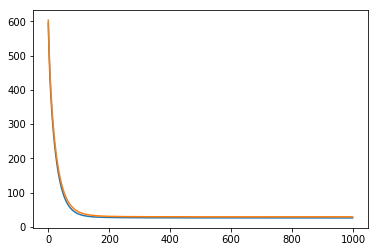

In [165]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)